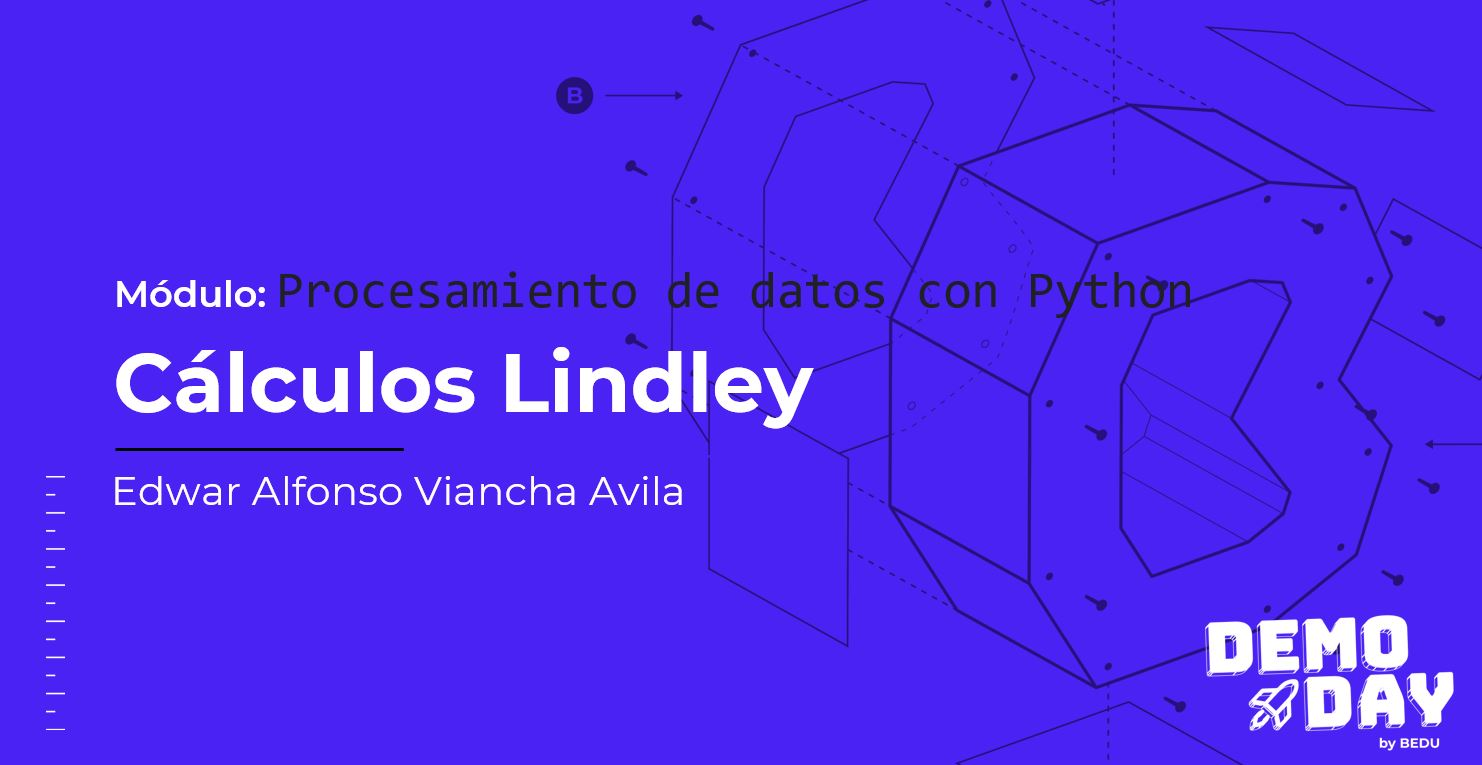

In [1]:
# Cálculos para el KPI Portafolio del estudio Lindley

## IMPORT

In [2]:
# Se realizan los import

In [3]:
import pyodbc
import pandas as pd
import numpy as np
import pandasql as ps #conda install -c anaconda pandasql

## CONFIGURACIÓN

In [4]:
# Se configuran los parámetros de conexión

In [5]:
DB = {'servername': '******',
      'database': 'E_KO_Lindley',
     'username': '******',
     'password': '******'}

In [6]:
# Se definen los parámetros del cálculo

In [7]:
OlaID = 161
InterviewID = 0

## CONEXIÓN BD

In [8]:
# Se realiza la conexión la base de datos en SQL SERVER

In [9]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';UID=' + DB['username'] + ';PWD=' + DB['password'] + '')

## INGESTA DE DATOS

In [10]:
# Se realiza la consulta inicial de las entrevistas que se deben tener en cuenta en el cálculo

In [11]:
df_interview = pd.read_sql_query('SELECT ID, RefID, PDVRefID FROM dbo.interview WHERE OlaID = '+str(OlaID)+' AND [Status] = 4 AND ID = IIF('+str(InterviewID)+' = 0, ID, '+str(InterviewID)+');',conn)

In [12]:
#Se trae TODA la información de las entrevistas

In [13]:
df_interviewinfo_pre = pd.read_sql_query('SELECT \
A.[InterviewID] \
,A.[OlaID] \
,A.[FDE] \
,A.[PDVRefID] \
,A.[PDVID] \
,A.[UbicacionID1] \
,A.[UbicacionID2] \
,A.[UbicacionID3] \
,A.[CanalID1] \
,A.[CanalID2] \
,A.[ClaseID1] \
,A.[Active] \
,A.[Status] \
,A.[Flag] \
,A.[stills] \
,A.[PerfilID] \
,A.[TipoPromocionID] \
FROM [interface].[ROE_CALC_InterviewInfo] AS A WHERE A.[OlaID] = ' + str(OlaID),conn)

In [14]:
# Genero una lista con las entrevistas que entran en el cálculo

In [15]:
list_interview = df_interview['ID'].values.tolist()

In [16]:
# Se genera un DS con la información de solo las entrevistas que entran en el cálculo

In [17]:
df_interviewinfo = df_interviewinfo_pre[df_interviewinfo_pre['InterviewID'].isin(list_interview)]

In [18]:
# Se traen los KPIs a evaluar en este cálculo Portafolio (4) y Variedad (11)

In [19]:
df_subkpis_pre = pd.read_sql_query('SELECT \
m.olaid AS OlaID, \
m.PDVRefID, \
subkpis.ID_CANAL, \
subkpis.ID_MODELO ModeloID, \
subkpis.ID_SUBKPI SUB_KPI_ID \
FROM \
[interface].[ROE_CALC_PDV_MODELO] AS m \
INNER JOIN [IM].[REX_M_KPI] AS subkpis ON m.olaid = subkpis.OlaID AND m.Modelo = subkpis.ID_MODELO AND subkpis.ID_KPI IN (4 /*Portafolio (OFF)*/, 11  /*Variedad (ON)*/) \
WHERE subkpis.STATUS != \'Eliminar\' AND m.olaid = ' + str(OlaID),conn)

In [20]:
# Se asocia la información de los SUBKPIs a las entrevistas que se tendrán en cuenta en el cálculo

$\color{red}{\text{Aquí no logré seleccionar las columnas que queria en el DS final}}$

In [21]:
df_subkpis = pd.merge(df_subkpis_pre, df_interviewinfo, how = 'inner', left_on = ['ID_CANAL','PDVRefID'], right_on = ['CanalID1','PDVRefID'])

In [22]:
# Se trae la información de inventario

In [23]:
df_inventario_pre = pd.read_sql_query('SELECT \
INV.OlaID, \
INV.survey_id AS RefID, \
INV.brand_id, \
INV.pack_id, \
INV.inventory, \
INV.survey_area_type_id, \
INV.survey_poc_type_id, \
INV.SKURefID \
FROM [interface].[t_cust_inventory] INV WHERE INV.OlaID = ' + str(OlaID),conn)

In [24]:
# Se filtra la información de las entrevistas que se tendrán en cuenta en este cálculo

$\color{red}{\text{Esta parte me sacó una cana, por la conversión de datos. Algo bastante fácil, pero me sacó una cana. Por eso antes del join, hago el casteo. ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat}}$

In [25]:
df_inventario_pre['RefID'] = df_inventario_pre.RefID.astype(np.int64)

In [26]:
df_interview['RefID'] = df_inventario_pre.RefID.astype(np.int64)

In [27]:
df_inventario = pd.merge(df_interview, df_inventario_pre, how = 'inner', left_on = ['RefID'], right_on = ['RefID'])

In [28]:
# Se trae la información cruda de las entrevistas

$\color{red}{\text{Esta consulta toma bastante tiempo, y la detuve desde el notebook, pero la consulta sigue corriendo en el servidor}}$

In [29]:
df_DecodedInterviewInterfaceT_pre = pd.read_sql_query('SELECT \
A.[TemplateItemID] \
,A.[OlaID] \
,A.[interviewID] \
,A.[inter_refid] \
,A.[paisid] \
,A.[pais] \
,A.[canalid] \
,A.[canal] \
,A.[subcanalid] \
,A.[subcanal] \
,A.[pdv_refid] \
,A.[gecid] \
,A.[gec] \
,A.[rutaid] \
,A.[variableid] \
,A.[variable] \
,A.[marcaid] \
,A.[marca] \
,A.[categoriaid] \
,A.[categoria] \
,A.[skuid] \
,A.[sku] \
,A.[preguntaid] \
,A.[pregunta] \
,A.[valor] \
,A.[valor_real] \
,A.[pocid] \
,A.[poc] \
,A.[survey_area_type_id] \
,A.[area_type_description] \
,A.[area_description] \
,A.[survey_poc_type_id] \
,A.[poc_type_description] \
,A.[poc_description] \
,A.[preguntaid_unique] \
,A.[temperature_sk] \
,A.[expiration_date] \
,A.[poc_sovi_state_id] \
,A.[poc_sovi_state] \
,A.[SKURefID] \
,A.[PocOwner] \
,A.[GrupoMarca] \
,A.[Packid] \
,A.[GrupoPack] \
,A.[Skuko] \
FROM [dbo].[DecodedInterviewInterfaceT_MQUEST] AS A \
WHERE \
A.OlaID = ' + str(OlaID) + ' \
AND A.variableID = 13 \
AND A.valor_real > 0',conn)

In [30]:
df_DecodedInterviewInterfaceT = df_DecodedInterviewInterfaceT_pre[df_DecodedInterviewInterfaceT_pre['interviewID'].isin(list_interview)]

In [31]:
# Se trae el insumo que sirve de configuración para los cálculos

In [32]:
df_portafolio = pd.read_sql_query('SELECT \
* \
FROM interface.ROE_CALC_PORTAFOLIO \
WHERE \
OLA = ' + str(OlaID) + ' \
AND CANAL_ID = 145',conn)

## CÁLCULOS

In [33]:
# Se ejecuta primero para el canal OFF (145)

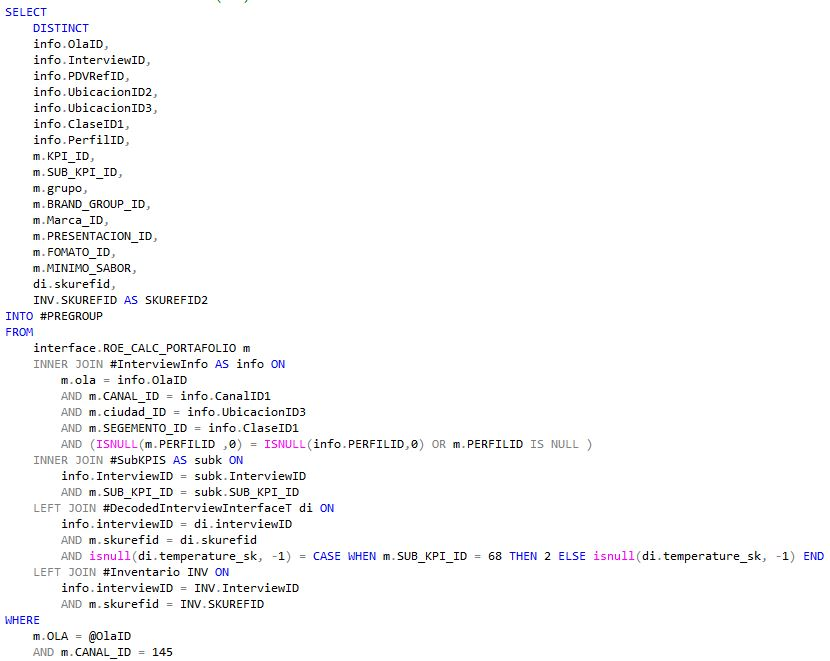

$\color{blue}{\text{Debo unir la información de 5 DF, entonces a falta de una mejor opción, hago el merge DF por DF}}$

In [34]:
df_portafolio["PerfilID"].fillna("0", inplace = True)

In [35]:
df_interviewinfo["PerfilID"].fillna("0", inplace = True)

C:\Users\eviancha\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [36]:
df_portafolio['PerfilID'] = df_portafolio.PerfilID.astype(int)

$\color{red}{\text{No entendí por qué no funcionó el casteo}}$

In [37]:
#df_interviewinfo['PerfilID'] = df_interviewinfo.PerfilID.astype(object)

In [38]:
df_interviewinfo = df_interviewinfo.astype({'PerfilID': 'int'})

$\color{orange}{\text{Nota personal: me mata que esta cosa sea Case Sensitive}}$

In [39]:
df_pregroup_01 = pd.merge(df_portafolio, df_interviewinfo, how = 'inner', left_on = ['CANAL_ID', 'CiUDAD_ID', 'SEGEMENTO_ID'], right_on = ['CanalID1', 'UbicacionID3', 'ClaseID1'])

In [40]:
df_pregroup_02 = df_pregroup_01[["OlaID", "InterviewID", "PDVRefID", "UbicacionID2", "UbicacionID3", "ClaseID1", "PerfilID_x", "KPI_ID", "SUB_KPI_ID", "GRUPO", "BRAND_GROUP_ID", "Marca_ID", "PRESENTACION_ID", "FOMATO_ID", "MINIMO_SABOR", "skuRefID"]]

In [41]:
df_pregroup_02 = df_pregroup_02.drop_duplicates()

In [42]:
df_pregroup_03 = pd.merge(df_pregroup_02, df_subkpis, how = 'inner', left_on = ['InterviewID', 'SUB_KPI_ID'], right_on = ['InterviewID', 'SUB_KPI_ID'])

In [43]:
df_pregroup_03 = df_pregroup_03.drop_duplicates()

In [44]:
df_pregroup_04 = pd.merge(df_pregroup_03, df_DecodedInterviewInterfaceT, how = 'left', left_on = ['InterviewID', 'skuRefID'], right_on = ['interviewID', 'SKURefID'])

C:\Users\eviancha\AppData\Local\Temp/ipykernel_10416/4043326717.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'OlaID_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_pregroup_04 = pd.merge(df_pregroup_03, df_DecodedInterviewInterfaceT, how = 'left', left_on = ['InterviewID', 'skuRefID'], right_on = ['interviewID', 'SKURefID'])


In [45]:
df_pregroup_05 = df_pregroup_04[["OlaID_x", "InterviewID", "PDVRefID_x", "UbicacionID2_x", "UbicacionID3_x", "ClaseID1_x", "PerfilID_x", "KPI_ID", "SUB_KPI_ID", "GRUPO", "BRAND_GROUP_ID", "Marca_ID", "PRESENTACION_ID", "FOMATO_ID", "MINIMO_SABOR", "skuRefID"]]

In [46]:
df_pregroup_06 = df_pregroup_05.rename(columns = {'OlaID_x' : 'OlaID', 'PDVRefID_x' : 'PDVRefID', 'UbicacionID2_x' : 'UbicacionID2', 'UbicacionID3_x' : 'UbicacionID3', 'ClaseID1_x' : 'ClaseID1', 'PerfilID_x' : 'PerfilID'})

In [47]:
df_pregroup_06 = df_pregroup_06.drop_duplicates()

In [48]:
df_pregroup_07 = pd.merge(df_pregroup_06, df_inventario, how = 'left', left_on = ['InterviewID', 'skuRefID'], right_on = ['ID', 'SKURefID'])

In [49]:
df_pregroup_08 = df_pregroup_07.rename(columns = {'PDVRefID_x' : 'PDVRefID', 'OlaID_y' : 'OlaID', 'SKURefID' : 'SKURefID'})

In [50]:
df_pregroup_08 = df_pregroup_08.drop(columns = ['PDVRefID_y', 'OlaID_x', 'ID'])

$\color{orange}{\text{Tratando de recordar cómo borramos una columna repetida}}$

In [51]:
df_pregroup_08.groupby(by=["OlaID", "InterviewID", "PDVRefID", "UbicacionID2", "UbicacionID3", "ClaseID1", "PerfilID", "KPI_ID", "SUB_KPI_ID", "GRUPO", "BRAND_GROUP_ID", "Marca_ID", "PRESENTACION_ID", "FOMATO_ID", "MINIMO_SABOR"], dropna=False).sum()

RefID  \
OlaID InterviewID PDVRefID UbicacionID2 UbicacionID3 ClaseID1 PerfilID KPI_ID SUB_KPI_ID GRUPO              BRAND_GROUP_ID Marca_ID PRESENTACION_ID FOMATO_ID MINIMO_SABOR                
161.0 781709      475174   42           46           5511     0        4      28         AGUAS SS           12.0           NaN      NaN             2.0       1             510264460.0   
                                                                              31         FG MS              5.0            NaN      NaN             1.0       1             255132230.0   
                                                                                         FRESH              NaN            9937.0   NaN             2.0       1             255132230.0   
                                                                              76         1L/1.5L VRE        NaN            9.0      119.0           NaN       1             255132230.0   
                                                                                                                                    121.0           NaN       1             255132230.0   
...                                                                                                                                                                                 ...   
NaN   842814      504715   43           48           5511     0        4      214        SL SS              12.0           NaN      68.0            NaN       1                     0.0   
                                                                              221        MONSTER/TOPO CHICO 8.0            NaN      181.0           NaN       1                     0.0   
                                                                                                            22.0           NaN      NaN             1.0       1                     0.0   
                                                                                                                                                    2.0       1                     0.0   
                                                                                                            NaN            8904.0   28.0            NaN       1                     0.0   

                                                                                                                                                                            pack_id  \
OlaID InterviewID PDVRefID UbicacionID2 UbicacionID3 ClaseID1 PerfilID KPI_ID SUB_KPI_ID GRUPO              BRAND_GROUP_ID Marca_ID PRESENTACION_ID FOMATO_ID MINIMO_SABOR            
161.0 781709      475174   42           46           5511     0        4      28         AGUAS SS           12.0           NaN      NaN             2.0       1               135.0   
                                                                              31         FG MS              5.0            NaN      NaN             1.0       1                 3.0   
                                                                                         FRESH              NaN            9937.0   NaN             2.0       1                64.0   
                                                                              76         1L/1.5L VRE        NaN            9.0      119.0           NaN       1               119.0   
                                                                                                                                    121.0           NaN       1               121.0   
...                                                                                                                                                                             ...   
NaN   842814      504715   43           48           5511     0        4      214        SL SS              12.0           NaN      68.0            NaN       1                 0.0   
                                                                              221        MONSTER/TO

In [52]:
df_pregroup_08.dtypes

InterviewID              int64
PDVRefID                object
UbicacionID2             int64
UbicacionID3             int64
ClaseID1                 int64
PerfilID                 int32
KPI_ID                   int64
SUB_KPI_ID               int64
GRUPO                   object
BRAND_GROUP_ID         float64
Marca_ID               float64
PRESENTACION_ID        float64
FOMATO_ID              float64
MINIMO_SABOR             int64
skuRefID                object
RefID                  float64
OlaID                  float64
brand_id                object
pack_id                float64
inventory              float64
survey_area_type_id    float64
survey_poc_type_id     float64
SKURefID                object
dtype: object

In [53]:
print(df_pregroup_07.index)

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            9240953, 9240954, 9240955, 9240956, 9240957, 9240958, 9240959,
            9240960, 9240961, 9240962],
           dtype='int64', length=9240963)


In [54]:
print(df_portafolio)

       OLA  CANAL_ID       MODELO  CiUDAD_ID  SEGEMENTO_ID  KPI_ID  \
0      161       145   B ELEGIDAS         46          5513       4   
1      161       145   B ELEGIDAS         46          5513       4   
2      161       145   B ELEGIDAS         46          5513       4   
3      161       145   B ELEGIDAS         46          5513       4   
4      161       145   B ELEGIDAS         46          5513       4   
...    ...       ...          ...        ...           ...     ...   
77099  161       145  Tradicional         72          5513       4   
77100  161       145  Tradicional         72          5513       4   
77101  161       145  Tradicional         72          5513       4   
77102  161       145  Tradicional         72          5513       4   
77103  161       145  Tradicional         72          5513       4   

       SUB_KPI_ID                  GRUPO  BRAND_GROUP_ID  Marca_ID  ...  \
0              33        FG MS/PWD/FRESH             5.0       NaN  ...   
1        